# Dealing with imbalanced classes. 

* I use **hyperopt** to tune parameters of an **XGBoost-Classifier**. I then build a Voting CLassifier that combines votes from a Logistic Regression model, a Random Forest model and the XGBoostClassifier. 


* Using the Kaggle **Credit Card Fraud Detection** dataset. 


* Quoting from Kaggle: 

    - The datasets contains transactions made by credit cards in September 2013 by european cardholders.This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
    
    - Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.
    
    - Features V1-V28 are anonymized. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount.
    
    
* XGBoost 

    - is known for its excellent speed & performance (operations parallizable) on a variety on Machine Learning problems. 
    - Is an Ensemble algoritm. It uses CART decision trees as base learners. 
    
    - It is preferred for use when we have a large number of training samples. Number of training samples must be greater than the number of features. 
    
    - The complete parameter list can be found at https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst
    
    
* Hyperopt

    - Manual search, grid search and random search are common algorithms used for hyperparameter tuning. 
    - All these previous methods are un-informed: ie. they scan through the entire/randomly selected set of hyperparameters to select the best one. 
    - Hyperopt is a Bayasian optimization algorithm, it is classified as an 'informed search' algorithm as the score from the previous round of search, 'informs' the choice of a better set of hyperparameters. 
 
* Another extremely cool advantage of hyperopt is: 
    - There are a lot of machine learning algorithms. And many different configuration for preprocessing/ feature engineering. Hyperopt allows us to use an algorithm to search this large set of other algorithms for the best, without additional input on our part. 
    - The 'algo' parameter is customizable. I will only use the inbuilt tpe.suggest algo. It is known to work well for most use cases. 
    - My dataset does not need much pre-processing. 
    - So I will only try out hyperparameter tuning for XGBoost today. 

# Imports & read file

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import xgboost as xgb

%matplotlib inline
sns.set(style='ticks')
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

data = pd.read_csv("../input/creditcardfraud/creditcard.csv")

C:\Users\Orpita Das\Documents\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Orpita Das\Documents\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Orpita Das\Documents\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  depr

# Explore data

In [2]:
data.info()
data.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,-0.915427,-1.040458,-0.031513,-0.188093,-0.084316,0.041333,-0.302620,-0.660377,0.167430,-0.256117,0.382948,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [3]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


* 30 feature columns in dataset. 
    - We don't know what V1-V26 are, but we know they have been scaled (boxplots show a similar range of values, to confirm).
    - Additionally,  'Time' in seconds, over a period of 2 days, is available. 
    - Majority of transactions are of a smaller 'Amount', mean is USD 88, range is ~ USD 0 - USD 25,691 range.
    
    
* No null values in dataset. 


* Imbalanced classes can be seen below. 

In [4]:
# Target contains imbalanced classes
data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

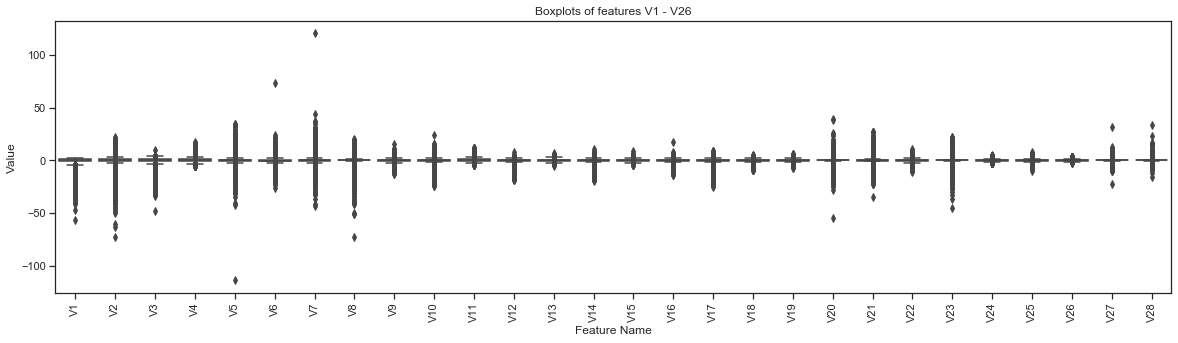

Text(0.5, 1.0, 'Boxplot of Amount feature')

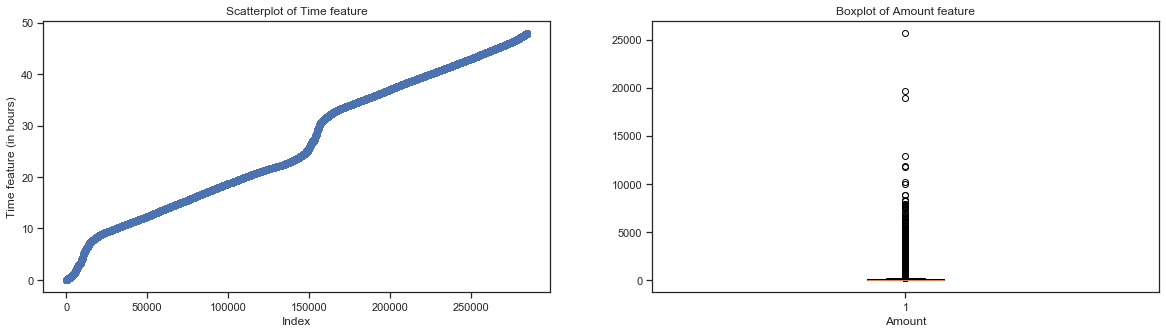

In [5]:
# Boxplot of variables V1 - V28
plt.figure(figsize=(20,5))
sns.boxplot(data=data.drop(['Time', 'Amount', 'Class'], axis=1))
plt.xticks(rotation=90)
plt.title('Boxplots of features V1 - V26')
plt.xlabel('Feature Name')
plt.ylabel('Value')
plt.show()

#datelist=pd.date_range("00:00:00", "23:59:59", freq="S")
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.scatter(data.index, data['Time']/(60*60))
ax1.set_xlabel('Index')
ax1.set_ylabel('Time feature (in hours)')
ax1.set_title('Scatterplot of Time feature')
ax2.boxplot(data['Amount'])
ax2.set_xlabel('Amount')
ax2.set_title('Boxplot of Amount feature')

# Preprocessing

In [6]:
# Scaling 'Time' and 'Amount'
std_scaler = StandardScaler()

data['scaled_amount'] = std_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
data['scaled_time'] = std_scaler.fit_transform(data['Time'].values.reshape(-1,1))

In [7]:
# Split data into training, holdout & test set
X_train, X_rest, y_train, y_rest= train_test_split(data.drop(['Class','Time','Amount'], axis=1), data.Class, 
                                                   test_size=0.4, random_state=123)
X_hold, X_test, y_hold, y_test= train_test_split(X_rest, y_rest, 
                                                   test_size=0.5, random_state=123)

# Models

## XGBoost

### Baseline model using XGBClassifier.

In [8]:
clf = xgb.XGBClassifier(n_estimators=150, seed=123)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_hold)
accuracy = accuracy_score(y_hold, y_pred)
print("accuracy: %f" % (accuracy))
print('As 99.828% of the data is class 0, the 99.927% heavily biased accuracy does not tell us much about the quality of our model .')

f1 = f1_score(y_hold, y_pred)
print("f1 score is a better metric: %f" % (f1))

print(confusion_matrix(y_hold, y_pred))
print(classification_report(y_hold, y_pred))

accuracy: 0.999631
As 99.828% of the data is class 0, the 99.927% heavily biased accuracy does not tell us much about the quality of our model .
f1 score is a better metric: 0.887701
[[56857     3]
 [   18    83]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56860
           1       0.97      0.82      0.89       101

    accuracy                           1.00     56961
   macro avg       0.98      0.91      0.94     56961
weighted avg       1.00      1.00      1.00     56961



### Sampling & Models : Decreases performance

* **OVERSAMPLING OR UNDERSAMPLING SHOULD ONLY BE APPLIED TO TRAIN.** 

* #### Undersampling : Precision very low, Recall is high. 

In [9]:
y_0=y_train[y_train==0]
y_1=y_train[y_train==1]
y_0_under=y_0.sample(n=len(y_1), random_state=123)
y_under=pd.concat([y_0_under,y_1]).sample(frac=1, random_state=123)
X_under=X_train.reindex(y_under.index)

In [10]:
# Target is no longer imbalanced. 
pd.DataFrame(y_under)['Class'].value_counts()

1    285
0    285
Name: Class, dtype: int64

In [11]:
# Target is no longer imbalanced. 
pd.DataFrame(y_under)['Class'].value_counts()

clf = xgb.XGBClassifier(n_estimators=150, seed=123)
clf.fit(X_under, y_under)
y_pred = clf.predict(X_hold)
print(confusion_matrix(y_hold, y_pred))
print(classification_report(y_hold, y_pred))

[[54812  2048]
 [    6    95]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56860
           1       0.04      0.94      0.08       101

    accuracy                           0.96     56961
   macro avg       0.52      0.95      0.53     56961
weighted avg       1.00      0.96      0.98     56961



#### Random Oversampling : Precision very low, Recall high

In [12]:

method = RandomOverSampler()
X_over, y_over = method.fit_resample(X_train,y_train)
X_over = pd.DataFrame(X_over, columns=['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'scaled_amount',
       'scaled_time'])

C:\Users\Orpita Das\Documents\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [13]:
# Target is no longer imbalanced. 
pd.DataFrame(y_over)[0].value_counts()

1    170599
0    170599
Name: 0, dtype: int64

In [14]:
clf = xgb.XGBClassifier(n_estimators=150, seed=123)
clf.fit(X_over, y_over)
y_pred = clf.predict(X_hold)
print(confusion_matrix(y_hold, y_pred))
print(classification_report(y_hold, y_pred))

[[56853     7]
 [   14    87]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56860
           1       0.93      0.86      0.89       101

    accuracy                           1.00     56961
   macro avg       0.96      0.93      0.95     56961
weighted avg       1.00      1.00      1.00     56961



#### Synthetic Minority Oversampling: Precision very low, Recall high.

* SMOTE is an improved version of Random Oversampling. But this is useful only when all undersampled cases are similar.

In [15]:
method = SMOTE()
X_over, y_over = method.fit_resample(X_train,y_train)
X_over = pd.DataFrame(X_over, columns=['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'scaled_amount',
       'scaled_time'])

C:\Users\Orpita Das\Documents\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [16]:
# Target is no longer imbalanced. 
pd.DataFrame(y_over)[0].value_counts()

1    170599
0    170599
Name: 0, dtype: int64

In [17]:
clf = xgb.XGBClassifier(n_estimators=150, seed=123)
clf.fit(X_over, y_over)
y_pred = clf.predict(X_hold)
print(confusion_matrix(y_hold, y_pred))
print(classification_report(y_hold, y_pred))

[[56844    16]
 [   13    88]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56860
           1       0.85      0.87      0.86       101

    accuracy                           1.00     56961
   macro avg       0.92      0.94      0.93     56961
weighted avg       1.00      1.00      1.00     56961



### XGBoostClassifier does better on unaltered data. Under/oversampling techniques decrease performance. 

* This is an interesting result. 

* Random Forests and Logistic Regression methods are commonly used for imbalanced class data. These do well with varius sampling strategies. Autoencoder Neural Network work very well to model imbalanced classes. 

* XGBoostClassifier does better with the original data. It is faster than most ML algorithms AND needs less preprocessing! 

* Let's improve out XGBoostClassifier through hyperparameter tuning. 

### Using hyperopt for XGBoostClassifier hyperparameter tuning 

* Parameter spaces can be built from manually entering values or selecting from one of these distrbutions.
    - hp.choice(label, options) — Returns one of the options, which should be a list or tuple.
    - hp.randint(label, upper) — Returns a random integer between the range (0, upper).
    - hp.uniform(label, low, high) — Returns a value uniformly between low and high.
    - hp.quniform(label, low, high, q) — Returns a value round(uniform(low, high) / q) * q, i.e it rounds the decimal values and returns an integer
    - hp.normal(label, mean, std) — Returns a real value that’s normally-distributed with mean and standard deviation sigma.
    
    
* The function optimized by hyperopt always minimizes - so we have to return 1-f1_score, in order to maximize this metric of our choice. 


* An odd feature: parameter names have to be provided twice in the parameter selection space. 


* XGBoost uses a special matrix type called a DMatrix. xgb.XGBClassifier automatically groups the data in a DMatrix, but when using cross validation or more complicated code, we must explicitly convert data to a DMatrix first. 


* the Trials() function stores data as the hyperopt algorithm progresses. It allows us to learn a few details about the internal working of the hyperopt algorithm. Running the Trials() function is optional. 



In [18]:
# Below code has been commented out because it takes time a long time (~30 mins with. 8 cores, GPU acceleration) 
# to run on every commit. So it was run once and commented out.
# defining the space for hyperparameter tuning
'''
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),'gamma': hp.uniform ('gamma', 1,9),
       'reg_alpha' : hp.quniform('reg_alpha', 1,180,1),
       'reg_lambda' : hp.uniform('reg_lambda', 0,1),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
       'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1)
       }

def hyperparameter_tuning(space):
    clf=xgb.XGBClassifier(max_depth = int(space['max_depth']), gamma = space['gamma'],
                         reg_alpha = int(space['reg_alpha']),min_child_weight=space['min_child_weight'],
                         colsample_bytree=space['colsample_bytree'],eta= 0.8, nthread=-1, 
                         scale_pos_weight = np.sqrt(sum(y_train==0)/sum(y_train==1)),
                          n_estimators=150, random_state=123)
    evaluation = [( X_train, y_train), ( X_hold, y_hold)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    y_pred = clf.predict(X_hold)
    recall = recall_score(y_hold, y_pred)
    print(classification_report(y_hold, y_pred))
    # We want to ensure that every fraud case is reported. 
    # Even if we tradeoff a large number of false positives. 
    # So we will maximize recall (ie. minimize 1-recall)
    print ("Recall:", recall)
    return {'loss': 1-recall, 'status': STATUS_OK }


# run the hyper paramter tuning
trials = Trials()

best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100)

print (best)
'''

'\nspace={\'max_depth\': hp.quniform("max_depth", 3, 18, 1),\'gamma\': hp.uniform (\'gamma\', 1,9),\n       \'reg_alpha\' : hp.quniform(\'reg_alpha\', 1,180,1),\n       \'reg_lambda\' : hp.uniform(\'reg_lambda\', 0,1),\n       \'colsample_bytree\' : hp.uniform(\'colsample_bytree\', 0.5,1),\n       \'min_child_weight\' : hp.quniform(\'min_child_weight\', 0, 10, 1)\n       }\n\ndef hyperparameter_tuning(space):\n    clf=xgb.XGBClassifier(max_depth = int(space[\'max_depth\']), gamma = space[\'gamma\'],\n                         reg_alpha = int(space[\'reg_alpha\']),min_child_weight=space[\'min_child_weight\'],\n                         colsample_bytree=space[\'colsample_bytree\'],eta= 0.8, nthread=-1, \n                         scale_pos_weight = np.sqrt(sum(y_train==0)/sum(y_train==1)),\n                          n_estimators=150, random_state=123)\n    evaluation = [( X_train, y_train), ( X_hold, y_hold)]\n    \n    clf.fit(X_train, y_train,\n            eval_set=evaluation, eval_metric

* Some of the best parameters and outputs from hyperparameter tuning.

* colsample_bytree = 0.9797504331289699, 
* gamma = 8.736312595289913, max_depth = 7, 
* min_child_weight = 9, n_estimators = 1, 
* reg_alpha = 62, 
* reg_lambda = 0.1083378611307041

* colsample_bytree= 0.7356225471858802,
*  gamma = 5.0244632204209765,
*  max_depth=15,
*  min_child_weight=4,
*  reg_alpha = 1,
*  reg_lambda = 0.49906388627478493,
*  eta= 0.8, nthread=-1, n_estimators=50, seed=123


              precision    recall  f1-score   support                              

           0       1.00      1.00      1.00    142147
           1       0.90      0.80      0.85       257

*     accuracy                           1.00    142404
*    macro avg       0.95      0.90      0.92    142404
* weighted avg       1.00      1.00      1.00    142404
  
*   colsample_bytree=0.9542777541496836,
*                         gamma=3.058617785278704,
*                         max_depth=5,
*                         min_child_weight=9,
*                         reg_alpha=110,
*                        reg_lambda=0.3025381002078801, 
*                        scale_pos_weight = np.sqrt(sum(y_train==0)/sum(y_train==1)),
*                        eta= 0.8, nthread=-1, n_estimators=50, seed=123

* [[71015    55]
*  [   17   115]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71070
           1       0.68      0.87      0.76       132

*     accuracy                           1.00     71202
*    macro avg       0.84      0.94      0.88     71202
* weighted avg       1.00      1.00      1.00     71202


In [20]:
# Model with best parameters 
clf = xgb.XGBClassifier(colsample_bytree = 0.9797504331289699, 
                        gamma = 8.736312595289913, max_depth = 7, 
                        min_child_weight = 9, n_estimators = 150, 
                        reg_alpha = 62, 
                        reg_lambda = 0.1083378611307041,
                        scale_pos_weight = np.sqrt(sum(y_train==0)/sum(y_train==1)),
                        eta= 0.8, nthread=-1, seed=123)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_hold)
print(confusion_matrix(y_hold, y_pred))
print(classification_report(y_hold, y_pred))

# Default parameters in baseline model (80% recall, 82% f1 score)
'''
colsample_bytree= 1,
 gamma = 0,
 max_depth = 6,
 min_child_weight = 1,
 reg_alpha = 0,
 reg_lambda = 1
'''

[[56816    44]
 [   15    86]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56860
           1       0.66      0.85      0.74       101

    accuracy                           1.00     56961
   macro avg       0.83      0.93      0.87     56961
weighted avg       1.00      1.00      1.00     56961



'\ncolsample_bytree= 1,\n gamma = 0,\n max_depth = 6,\n min_child_weight = 1,\n reg_alpha = 0,\n reg_lambda = 1\n'

In [21]:
# Checking model performance by 3-fold cross-validation
clf = xgb.XGBClassifier(colsample_bytree = 0.9797504331289699, 
                        gamma = 8.736312595289913, max_depth = 7, 
                        min_child_weight = 9, n_estimators = 150, 
                        reg_alpha = 62, 
                        reg_lambda = 0.1083378611307041,
                        scale_pos_weight = np.sqrt(sum(y_train==0)/sum(y_train==1)),
                        eta= 0.8, nthread=-1)
print(cross_val_score(clf, X_train, y_train, cv=3, scoring='recall'))

[0.86315789 0.78947368 0.85263158]


* The tuned model improves recall by 7%. f1 score reduces from 82% to 80%: 
    - The tuned model is better able to classify the fraud cases
    - it has alpha & lambda regularization as well as a higher gamma value (higher gamma = greater gain threshold for maintaining nodes, and thus, more pruning). 
    - A fraction of the features are subsampled in the tuned model (colsample_bytree) . We thus make the model run faster (and introduce regularization) without losing out on performance. 
    - The tuned model builds deeper trees . A greater number of interactions can be captured by the tuned model. 
    - A higher weight threshold is used to allow/deny subdivision of node, in the tuned model. 
    
    
* Further tuning with a lower learning rate (eta) can be done to narrow down on a better model. 

* Finally. the precision-recall threshold should be changed to ensure better recall, if possible. We see in the current precision - recall curve, there is a sharp drop in precision if we require >80% recall. But we also see that the mean amount of 492 fraud transactions is higher than the mean of 284315 non-fraud transactions. Considering the higher losses, the bank may want to increase recall to ~99% even if it means more calls to customers to check on legitimate transctions flagged as fraud.       

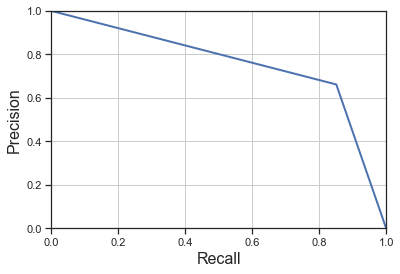

In [22]:
# Plot precision recall curve for current best model. 
precisions, recalls, thresholds = precision_recall_curve(y_hold, y_pred)
plt.plot(recalls, precisions, "b-", linewidth=2)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

Text(0.5, 1, 'Mean Amounts for non-fraud (label 0) and fraud (label 1) transactions')

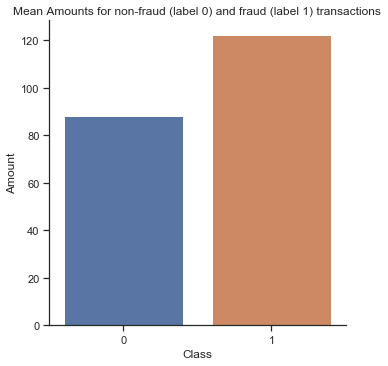

In [23]:
# Plot mean Amounts of non-fraud (label 0) and fraud (label 1) transactions
sns.catplot(x='Class', y='Amount', data=data, kind='bar', ci=None)
plt.title('Mean Amounts for non-fraud (label 0) and fraud (label 1) transactions' )

## Logistic Regression

In [24]:
clf = LogisticRegression(class_weight='balanced',max_iter=200, random_state=123)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_hold)
print(confusion_matrix(y_hold, y_pred))
print(classification_report(y_hold, y_pred))

[[55534  1326]
 [    8    93]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56860
           1       0.07      0.92      0.12       101

    accuracy                           0.98     56961
   macro avg       0.53      0.95      0.56     56961
weighted avg       1.00      0.98      0.99     56961



In [25]:
param_grid = {'C' : [0.1, 1, 10, 100]}

clf = LogisticRegression(class_weight='balanced', max_iter=200, random_state=123, n_jobs=-1)
search = GridSearchCV(clf, param_grid, cv=3, scoring='recall')
search.fit(X_train, y_train)
y_pred = search.predict(X_hold)
print(confusion_matrix(y_hold, y_pred))
print(classification_report(y_hold, y_pred))
print('Best parameters: ', search.best_params_)


[[55528  1332]
 [    8    93]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56860
           1       0.07      0.92      0.12       101

    accuracy                           0.98     56961
   macro avg       0.53      0.95      0.55     56961
weighted avg       1.00      0.98      0.99     56961

Best parameters:  {'C': 0.1}


* This model has lower scores but does better after crosss-validation.

## Random Forest

In [26]:
rf = RandomForestClassifier(max_depth=110, min_samples_split=10, random_state = 123, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_hold)
print(confusion_matrix(y_hold, y_pred))
print(classification_report(y_hold, y_pred))

[[56858     2]
 [   22    79]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56860
           1       0.98      0.78      0.87       101

    accuracy                           1.00     56961
   macro avg       0.99      0.89      0.93     56961
weighted avg       1.00      1.00      1.00     56961



* Random Forests generally do not benefit much from hypertuning. 

## Voting Classifier

* We now have three models with diverse performance measures. 


* Logistic Regression model shows highest recall, but very low precion & f1 score. 
* XGBoostClassifier shows a good recall, intermediate precision and f1 score. 
* Random Forest model shows highest precision, recall and f1 scores are good too. 


* A voting classifier will support stronger detection of fraud cases, than by using the models individually and thus protect banks from large losses. 

In [33]:
xgb_cf = xgb.XGBClassifier(colsample_bytree = 0.9797504331289699, 
                        gamma = 8.736312595289913, max_depth = 7, 
                        min_child_weight = 9, n_estimators = 150, 
                        reg_alpha = 62, 
                        reg_lambda = 0.1083378611307041,
                        scale_pos_weight = np.sqrt(sum(y_train==0)/sum(y_train==1)),
                        eta= 0.8, nthread=-1, n_jobs=-1)
lr_cf = LogisticRegression(C= 0.1, class_weight='balanced', n_jobs=-1)
rf_cf = RandomForestClassifier(max_depth=110, min_samples_split=10, n_jobs=-1)


vote = VotingClassifier (estimators = [('xgb_cf', xgb_cf), ('lr_cf', lr_cf), ('rf_cf', rf_cf)], 
                         voting='hard', weights = [1, 1.3, 1], n_jobs=-1)
vote.fit(X_train,y_train)
y_pred = vote.predict(X_hold)
print(confusion_matrix(y_hold, y_pred))
print(classification_report(y_hold, y_pred))

[[56822    38]
 [   15    86]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56860
           1       0.69      0.85      0.76       101

    accuracy                           1.00     56961
   macro avg       0.85      0.93      0.88     56961
weighted avg       1.00      1.00      1.00     56961



## Test set performance

In [34]:
prediction = vote.predict(X_test)
print(confusion_matrix(y_test, prediction))
print(classification_report(y_test, prediction))

[[56801    55]
 [   18    88]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56856
           1       0.62      0.83      0.71       106

    accuracy                           1.00     56962
   macro avg       0.81      0.91      0.85     56962
weighted avg       1.00      1.00      1.00     56962

